#  Projet Immobilier : Estimer le prix d'une maison


**Notre mission :** Une agence immobilière nous a confié un historique de 10 000 ventes. Notre but est de créer un modèle capable de prédire le prix d'une maison en fonction de ses caractéristiques (surface, quartier, etc.).

Pour cela nous allons adopter la demarche suivante structurée en plusieurs etapes:

### Étape 1 : Chargement et Inspection des Données
Avant de modéliser quoi que ce soit, nous devons comprendre ce que nous avons entre les mains. C'est à dire importer nos données, les visualiser et comprendre la structure meme de nos données. Une étape crutiale qui déterminera la suite de notre projet ainsi que la qualité de nos resultats. 

In [1]:
## Importation des bibliothèques necessaires pour la manipulation de nos données

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration pour des graphiques plus beaux
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Bibliothèques importées avec succès !")

Bibliothèques importées avec succès !


Chargeons maintenant notre fichier `housing_data.csv`.

 Après l'importation des bibliothèques pour la manipulation de nos données, nous allons maintenant charger nos données afin de voir à quoi elles ressemblent. 

In [30]:
df = pd.read_csv('housing_data.csv')

# 1. Regardons à quoi ressemblent les 5 premières lignes
display(df.head())

,surface_m2,nb_chambres,quartier,annee_construction,garage,prix
0,139.0,5,Quartier Résidentiel,1979,1,497800
1,160.0,7,Banlieue Sud,1953,1,389400
2,237.0,9,Banlieue Sud,1989,0,718800
3,135.0,5,Quartier Résidentiel,2023,0,600200
4,64.0,2,Banlieue Nord,1970,1,201900


Nous pouvons voir a travers les 5 premières lignes que nous avons une base de données avec 5 variables a savoir surface_m2, quartier, annee_construction, garage et prix.

###  Analyse Rapide
Maintenant nous allons analyser les colonnes : `surface_m2`, `nb_chambres`, `quartier`, `garage` et `prix`.

Il s'agit de  vérifier la **santé** de nos données : 
- Avons-nous des valeurs manquantes (NaN) ?
- Les types de données sont-ils corrects (int, float, object) ?

In [31]:
# Verfions donc nos données a travers la foinction 'info()' de python
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   surface_m2          9811 non-null   float64
 1   nb_chambres         10000 non-null  int64  
 2   quartier            10000 non-null  object 
 3   annee_construction  10000 non-null  int64  
 4   garage              10000 non-null  int64  
 5   prix                10000 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


Nous constaons de prime a bord que la variables `surface_m2` a moins de 10 000 valeurs : Cela confirme qu'il y a des données manquantes (NaN).
Aussi les types de données : int64 (entiers) pour les variables `nb_chambres`, `annee_construction`, `garage` et `prix`; ce qui est normale pour des varaibles comme elles. On constate aussi float64 (décimal) pour la variable `surface_m2` est logique aussi (ex: 45.5 m²). On constate que la variable `quartier` est de type object donc c'est du texte, ce qui posera problème aux maths plus tard dont il faudra le transformer.

In [ ]:
# Statistiques descriptives pour repérer certains problèmes dans la base (Outliers)
df.describe()

,surface_m2,nb_chambres,annee_construction,garage,prix
count,9811.000000,10000.000000,10000.000000,10000.000000,1.000000e+04
mean,99.765977,3.490800,1987.008800,0.600100,3.608528e+05
std,57.057627,2.181649,21.642716,0.489902,2.726252e+05
min,20.000000,1.000000,1950.000000,0.000000,4.140000e+04
25%,58.000000,2.000000,1968.000000,0.000000,1.942000e+05
50%,87.000000,3.000000,1987.000000,1.000000,2.941000e+05
75%,127.000000,5.000000,2006.000000,1.000000,4.509250e+05
max,620.000000,10.000000,2024.000000,1.000000,7.436000e+06


--- Valeurs manquantes ---
surface_m2            189
nb_chambres             0
quartier                0
annee_construction      0
garage                  0
prix                    0
dtype: int64


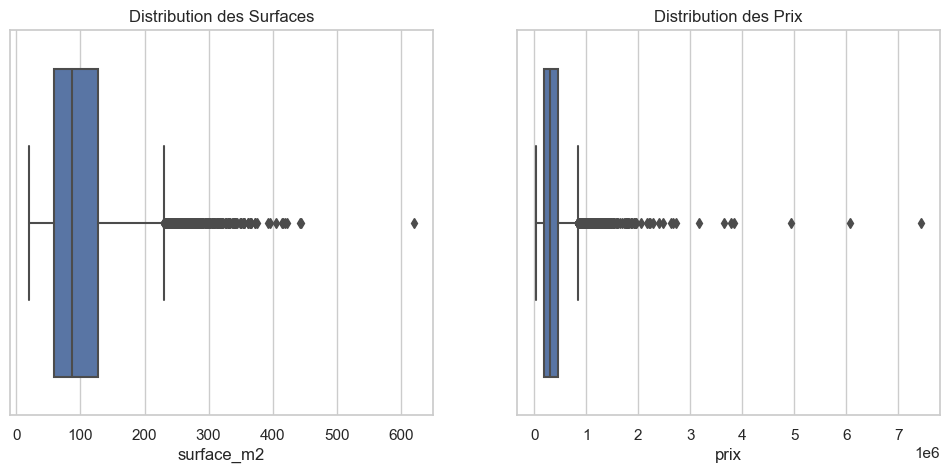

In [19]:
# 1. Compter exactement les trous
print("--- Valeurs manquantes ---")
print(df.isnull().sum())

# 2. Visualiser les anomalies (Outliers) avec des "Boxplots"

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1) # Graphique de gauche
sns.boxplot(x=df['surface_m2'])
plt.title("Distribution des Surfaces")

plt.subplot(1, 2, 2) # Graphique de droite
sns.boxplot(x=df['prix'])
plt.title("Distribution des Prix")

plt.show()

A travers la visualisation, nous voyons des points noirs isolés, ce sont donc des outliers, ce sont des valeurs qui s'ecartent de la réalité. Si nous les maintenons et nous apprenons avec eux, le modèle va croire qu'une maison de 5000m² coûte 100€ (ou l'inverse) et donc biaiséra nos résultats. Il faut donc procéder au netoyage de la base.

### Etape 2: Traitement de la base de données 

Nous allons procédons au nettoyage de la base de données afin de garder une base propre pour notre travail.

In [33]:
# 1. Remplir les valeurs manquantes (Imputation)
median_surface = df['surface_m2'].median()
df['surface_m2'] = df['surface_m2'].fillna(median_surface)
print(f"✅ Surfaces manquantes remplacées par la médiane : {median_surface} m2")

# 2. Supprimer les outliers (filtrage)
# On garde uniquement ce qui semble "raisonnable"
# Par exemple : Surface < 400m2 et Prix < 2 000 000 (ce qui couvre 99% des cas normaux)
df_clean = df[ (df['surface_m2'] < 400) & (df['prix'] < 2000000) ].copy()

print(f"\nAvant nettoyage : {len(df)} maisons")
print(f"Après nettoyage : {len(df_clean)} maisons")
print(f"🗑️ Maisons supprimées (erreurs) : {len(df) - len(df_clean)}")

# On remplace notre df par la version propre
df = df_clean

✅ Surfaces manquantes remplacées par la médiane : 87.0 m2

Avant nettoyage : 10000 maisons
Après nettoyage : 9976 maisons
🗑️ Maisons supprimées (erreurs) : 24


En ce qui concerne la gestion des outliers il y a deux façons de définir "à partir de quand c'est aberrant" :

1. L'Expertise Métier (La méthode "Bon Sens")
C'est ce que nous avons fait ici en regardant les graphiques.

Visuellement : Sur les boxplots, on voit le "bloc" principal de données. Les points qui se détachent nettement (les points noirs isolés) indiquent une rupture.
Réalité : Une maison de 5000 m² ? C'est un château, pas une maison standard. Un prix de 20 millions alors que la moyenne est à 400k ? C'est probablement une erreur de saisie (un zéro en trop).
C'est pourquoi nous avons decider de ne garder que les maisons dont la surface_m2 < 400m2 et Prix < 2 000 000 (ce qui couvre 99% des cas normaux)


2. La Méthode Statistique (L'Écart Interquartile ou IQR)
C'est la méthode rigoureuse utilisée par les boxplots. Une valeur est mathématiquement considérée comme outlier si elle sort de ces bornes :

Q1 = Le seuil des 25% des maisons les moins chères.
Q3 = Le seuil des 75% (les plus chères).
IQR (L'écart) = Q3 - Q1.
Borne Min = Q1 - 1.5 * IQR.
Borne Max = Q3 + 1.5 * IQR.

In [ ]:
##Pour méthode Statistique

# 1. On recharge les données pour être sûrs de travailler sur le dataset complet
#df = pd.read_csv('housing_data.csv')
#df['surface_m2'] = df['surface_m2'].fillna(df['surface_m2'].median())

#def nettoyer_iqr(df, variable):
    # Calcul des quartiles
    #Q1 = df[variable].quantile(0.25)
    #Q3 = df[variable].quantile(0.75)
    #IQR = Q3 - Q1
    
    # Calcul des bornes (la règle du 1.5 * IQR)
    #borne_min = Q1 - 1.5 * IQR
    #borne_max = Q3 + 1.5 * IQR
    
    #print(f"Variable '{variable}' : on garde entre {borne_min:.0f} et {borne_max:.0f}")
    
    # On filtre
    #return df[ (df[variable] >= borne_min) & (df[variable] <= borne_max) ]

# 2. On applique le nettoyage magique
#print(f"Nombre de maisons au départ : {len(df)}")
#df = nettoyer_iqr(df, 'surface_m2')
#df = nettoyer_iqr(df, 'prix')
#print(f"Nombre de maisons après nettoyage : {len(df)}")

#Comme nous l'avaons déjà fait selon notre intuition nous vous laissons de soin 
# de choisir entre la notre et celle-ci. Pour celle-ci il faut suffira de decommenter 
# les codes en supprimant les "#" et executer. 

In [34]:
#Nous revisualisons la base après le nettoyage
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9976 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   surface_m2          9976 non-null   float64
 1   nb_chambres         9976 non-null   int64  
 2   quartier            9976 non-null   object 
 3   annee_construction  9976 non-null   int64  
 4   garage              9976 non-null   int64  
 5   prix                9976 non-null   int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 545.6+ KB


Apres le nettoyage nous constatons qu'il nous reste 9976 observations par variables sur 10000 au départ. 

In [36]:
# Transformer 'quartier' en colonnes numériques (0 ou 1)
df = pd.get_dummies(df, columns=['quartier'], drop_first=True) ## drop_first=True évite la redondance

# Petit coup d'oeil au résultat final
print("Colonnes après transformation :")
print(df.columns.tolist())
display(df.head())

Colonnes après transformation :
['surface_m2', 'nb_chambres', 'annee_construction', 'garage', 'prix', 'quartier_Banlieue Sud', 'quartier_Centre-Ville', 'quartier_Quartier Résidentiel', 'quartier_Zone Industrielle']


,surface_m2,nb_chambres,annee_construction,garage,prix,quartier_Banlieue Sud,quartier_Centre-Ville,quartier_Quartier Résidentiel,quartier_Zone Industrielle
0,139.0,5,1979,1,497800,False,False,True,False
1,160.0,7,1953,1,389400,True,False,False,False
2,237.0,9,1989,0,718800,True,False,False,False
3,135.0,5,2023,0,600200,False,False,True,False
4,64.0,2,1970,1,201900,False,False,False,False


Pourquoi nous avons fait cette transformation?
Les ordinateurs ne comprennent pas "Centre-Ville" ou "Banlieue Sud". Ils ne comprennent que les maths. Nous avons une colonne qui pose problème : quartier (texte).

Il y a deux façons de la transformer :

Ordinal Encoding : Centre-Ville = 1, Banlieue = 2... . Mais celle-ci est dangereux car ça crée un ordre artificiel 1 < 2 que l'ordinateur peut considerer, alors que aucun ordre n'a de sens ici.

One-Hot Encoding (Dummies) : Créer une colonne par quartier (ex: quartier_CentreVille : 1 ou 0). C'est la méthode reine pour les catégories non ordonnées. Ca nous évite d'avoir un ordre artificiel laissant croire a l'ordinateur qu'il ya des quarties supérieurs a d'autres et donc biaiser la prédiction.
On voit donc apres exécution que la la colonne quartier a disparu, remplacée par quartier_Banlieue Sud, quartier_Centre-Ville, etc.

### Etape 3: Matrice de corrélation 
Nous voulons savoir : Qu'est-ce qui fait VRAIMENT grimper le prix ? La surface ? Le garage ? Le fait d'être en Centre-Ville ?

Pour cela, nous utilisons une "Heatmap" (Carte de chaleur). Plus la couleur est chaude (ou proche de 1.0), plus la relation est forte.


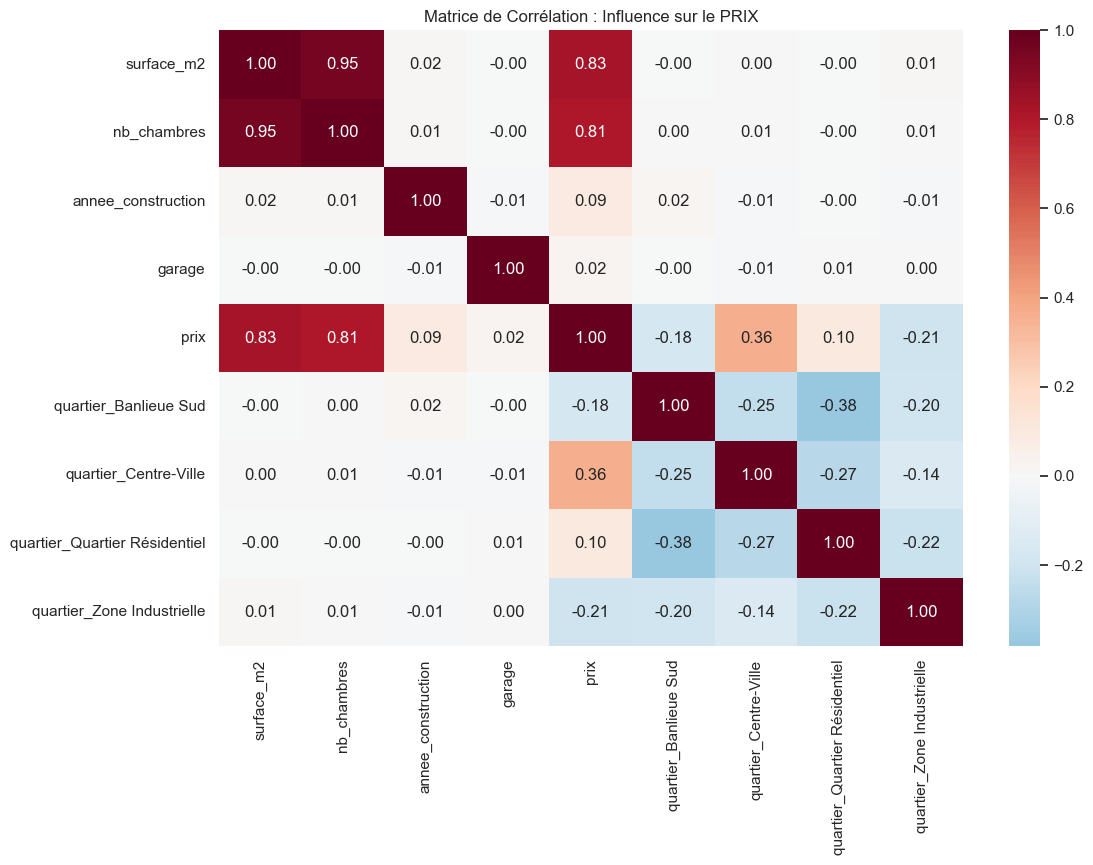

prix                             1.000000
surface_m2                       0.829327
nb_chambres                      0.806250
quartier_Centre-Ville            0.361271
quartier_Quartier Résidentiel    0.099130
annee_construction               0.087742
garage                           0.023145
quartier_Banlieue Sud           -0.176487
quartier_Zone Industrielle      -0.207718
Name: prix, dtype: float64


In [37]:

# Calculer les corrélations
correlation_matrix = df.corr()

# Afficher la Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, fmt=".2f")
plt.title("Matrice de Corrélation : Influence sur le PRIX")
plt.show()

# Zoom sur ce qui nous intéresse : le liens avec le PRIX
print(correlation_matrix['prix'].sort_values(ascending=False))

Nous constatons qu'il existe une forte corrélation positive entrensurface_m2, nb_chambres et prix. Par contre oil existe corrélation négative entre quartier_Banlieue Sud, quartier_Zone Industrielle.
Egalement il y a entre nb_chambres et surface_m2 une Multicollinéarité. C'est logique : plus c'est grand, plus il y a de chambres. En général, on évite de donner deux fois la même info au modèle, mais nous allons les garder pour l'instant Pour la suite de notre travail. 

### Etape 4: Entrainement de notre modèle 

Dans cette étape nous allons diviser nos données en deux :

L'Entraînement (Train set - 80%) : Les données que le modèle étudie pour apprendre.

L'Examen (Test set - 20%) : Des données qu'on lui cache, pour vérifier s'il triche (par coeur) ou s'il a vraiment compris.


In [40]:
#Importation de bibliothèque 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 1. On sépare les Cibles (y) des Caractéristiques (X)
X = df.drop('prix', axis=1) # Tout sauf le prix
y = df['prix']              # Juste le prix

# 2. On coupe en deux : 80% pour apprendre, 20% pour tester
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. On entraîne le modèle 
model = LinearRegression()
model.fit(X_train, y_train)

# 4. On l'évalue
score_train = model.score(X_train, y_train)
score_test = model.score(X_test, y_test)

print(f" Score sur l'entraînement (R²) : {score_train:.2f}")
print(f" Score sur le test (R²)        : {score_test:.2f}")

 Score sur l'entraînement (R²) : 0.89
 Score sur le test (R²)        : 0.87


On constate que le R² est de 0.87 sur le test, c'est excellent. Cela signifie que notre modèle a compris 89% de la logique des prix. De plus, les deux scores (0.89 et 0.87) sont très proches. Nous pouvons dire que notre modèle est stable (pas de sur-apprentissage/overfitting)

Mais concrètement un score de 87%, c'est bien beau, mais l'agent immobilier veut savoir par exemple si je vends cette maison, tu te trompes de 100€ ou de 50 000€ ?"? C'est pourquoi nous allons evaluer notre modèle a travers le RMSE (Root Mean Squared Error). C'est l'erreur moyenne en Euros.


### Etape 5: Evaluation de notre modèle

Nous allons donc evalué notre modèle et vpoir est-ce que les scores que nous avons sont donc pertinents ou juste flateur auquel. 

 Erreur Moyenne Absolue (MAE) : 52553 €
 Erreur Quadratique Moyenne (RMSE) : 84879 €
Moyenne des prix réels : 356739 €


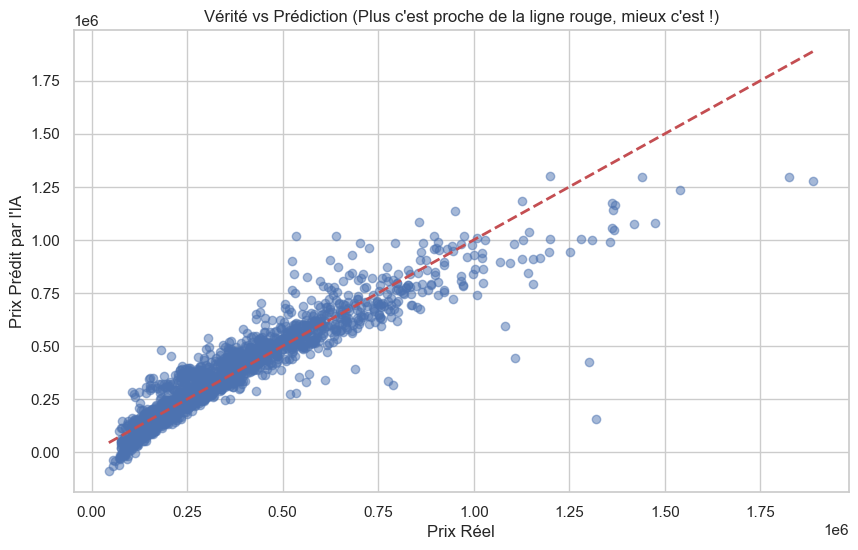

In [41]:
#Importation des bibliothèques
from sklearn.metrics import mean_absolute_error, mean_squared_error

# On fait des prédictions sur nos données de test
predictions = model.predict(X_test)

# On calcule l'erreur
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f" Erreur Moyenne Absolue (MAE) : {mae:.0f} €")
print(f" Erreur Quadratique Moyenne (RMSE) : {rmse:.0f} €")
print(f"Moyenne des prix réels : {y_test.mean():.0f} €")

# Visualisation : Réalité vs Prédiction
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Ligne rouge parfaite
plt.xlabel("Prix Réel")
plt.ylabel("Prix Prédit par l'IA")
plt.title("Vérité vs Prédiction (Plus c'est proche de la ligne rouge, mieux c'est !)")
plt.show()

En analysant  ces chiffres, on a :

Prix moyen d'une maison : 311 447 €

Erreur moyenne (MAE) : 52553 €

Cela signifie que notre modéle se trompe en moyenne de 16,87%. (52553 / 311447). Ce n'est pas mal pour un premier jet, mais on est un peu loin de l'objectif de +/- 5%, ce que souhaite de notre client.

 Donc on peut sûrement s'améliorer !

### Etape 6: Explaration d'autres modèles de prédictions 

Nous avons constater que notre modéle se trompe en moyenne de 16,87%. Ce qui n'est pas un meilleur résultats pour nous.

Il y a deux raisons possibles à cet écart :

La limite des données (Le Bruit) : Parfois, le prix dépend de l'humeur du vendeur, ce qu'on ne peut pas prédire.
La limite du modèle (La Simplicité) : La Régression Linéaire tire des traits droits. Mais peut-être que l'âge de la maison n'influence pas le prix de façon linéaire, par exemple une maison de 1900 est chère, une de 1970 pas chère, une de 2020 chère... c'est une courbe !. Nous allons donc essayé une méthode de régression non linéiare le "Random Forest" (Forêt Aléatoire). Cet modèle ne trace pas de ligne, il pose des milliers de questions ("Est-ce > 100m2 ? Si oui, est-ce Garage ?").

## Le modèle Random Forest (Non-Linéaire)

In [44]:
#Importation de biblithèque
from sklearn.ensemble import RandomForestRegressor

# On entraîne un modèle beaucoup plus puissant
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# On prédit
rf_predictions = rf_model.predict(X_test)

# On mesure
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
prix_moyen = y_test.mean()

print(f" Random Forest MAE : {rf_mae:.0f} € (soit {rf_mae/prix_moyen*100:.1f} % d'erreur)")
print(f" Random Forest RMSE : {rf_rmse:.0f} €")

 Random Forest MAE : 34178 € (soit 9.6 % d'erreur)
 Random Forest RMSE : 58607 €


Avec le modèle Random Forest on a gagné plus de 6 points (de 16,87% à 9.6%)/ Notre modéle se trompe en moyenne maintenant de 9.6%. Ce qui n'est peut-être pas un meilleur résultat  mais une amelioration par rapport au modèle précédent. 

